What is BERT?
Before diving into the code, let’s start by understanding what BERT is.

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained language model developed by Google. It's designed to understand the context of words in a sentence by looking at the words before and after them, which makes it powerful for tasks like text classification, question answering, and sentiment analysis.

Pre-trained means that BERT has already been trained on massive amounts of text (like books and websites) and has learned a lot about language. When you use BERT, you're fine-tuning this pre-trained model to perform a specific task, such as classifying text or predicting sentiment.

The overall process of using BERT:
Here’s what we’re doing from start to finish:

*   Input Text: You provide some text data that you want the model to classify or  process
*   Preprocessing: The raw text data is transformed into a format that BERT can understand.
*   Preprocessing: The raw text data is transformed into a format that BERT can understand.
*   BERT Encoder: BERT processes the text and returns powerful embeddings (representations) of the text.
*   Model Creation: We add a few extra layers (Dropout and Dense layers) to train the model on our specific task (e.g., binary classification).
Model Training: We then train the model with labeled data (for example, "spam" or "not spam").
*   Evaluation: After training, the model can make predictions on new text data.

link dataset : https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [1]:
#!pip install -U "tensorflow-text==2.15.*"
#!pip install -U "tf-models-official==2.15.*"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Replace 'path_to_file' with the actual path to your CSV
file_path = '/content/drive/My Drive/Datasets/IMDB Dataset.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [4]:
df.shape

(50000, 2)

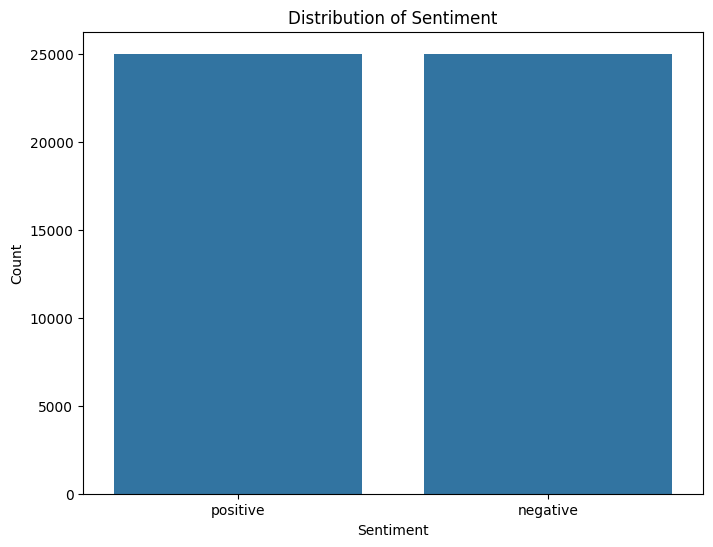

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
value_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment')
plt.show()

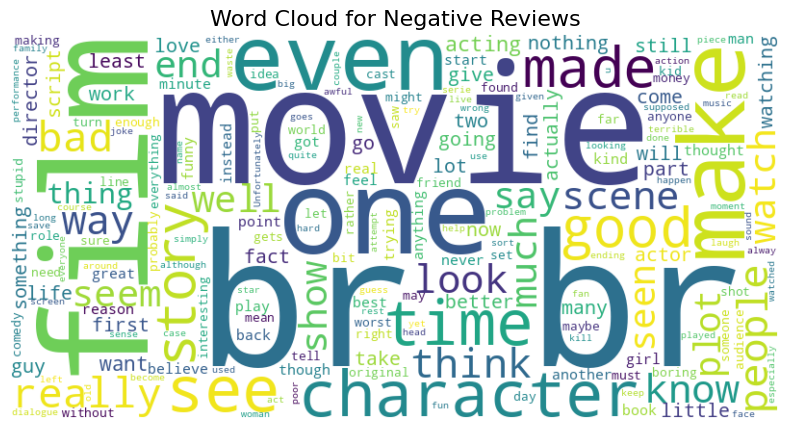

In [6]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Filter negative reviews
negative_reviews = df[df['sentiment'] == 'negative']['review']

# Combine all negative reviews into a single string
text = " ".join(review for review in negative_reviews)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Word Cloud for Negative Reviews", fontsize=16)
plt.show()


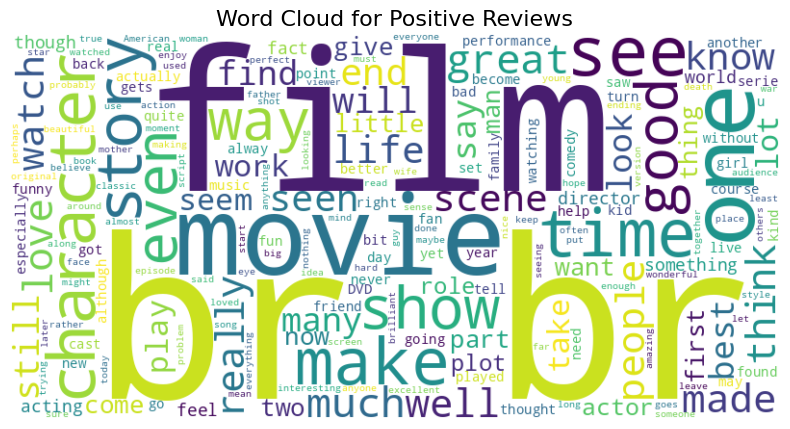

In [7]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Filter negative reviews
positive_reviews = df[df['sentiment'] == 'positive']['review']

# Combine all negative reviews into a single string
text = " ".join(review for review in positive_reviews)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off the axis
plt.title("Word Cloud for Positive Reviews", fontsize=16)
plt.show()


In [8]:
df['review_sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.sample(5)

,review,sentiment,review_sentiment
47135,"Compared to the recent gore flick HOSTEL, whic...",negative,0
24331,This was painful! Recently given away as a fre...,negative,0
33460,The Waiting Womans Ward of a large lying-in ho...,positive,1
34519,The stranger Jack (Matthew Lillard) arrives in...,negative,0
37919,There is a scene near the beginning after a sh...,negative,0


In [9]:
print(df['review'].head(1))


0    One of the other reviewers has mentioned that ...
Name: review, dtype: object


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],df['review_sentiment'], test_size=0.2)

In [12]:
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text

# Load BERT preprocessing layer from TensorFlow Hub
# This layer will process the input text, including tokenization,
# adding special tokens like [CLS], [SEP], and converting text to input IDs.
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# Load the BERT encoder model from TensorFlow Hub
# This layer will generate BERT embeddings from the preprocessed input text.
# The encoder is the core of the BERT model that understands the context of the text.
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [14]:
# Define the input layer for text data. The input will be a string.
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

# Preprocess the input text by tokenizing and preparing it in a format BERT can understand.
# This step often includes adding special tokens, padding, etc.
preprocessed_text = bert_preprocess(text_input)

# Pass the preprocessed text to the BERT encoder to get its rich, contextualized representations.
outputs = bert_encoder(preprocessed_text)





In [15]:
# Add a Dropout layer to prevent overfitting. It randomly sets 10% of the output units to zero during training.
# The Dropout rate is 0.1, meaning 10% of the units will be dropped.
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])

# Add a Dense layer with a single unit. This is typically used for binary classification tasks.
# The 'sigmoid' activation function outputs a probability between 0 and 1, which can be interpreted as class probabilities.
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Construct the final model by specifying the inputs and the final output layer.
# 'text_input' is the input, and 'l' is the output, which is the final decision from the Dense layer.
model = tf.keras.Model(inputs=[text_input], outputs=[l])


In [16]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                            

In [17]:
# Define the list of metrics that will be used to evaluate the model's performance during training and evaluation.
METRICS = [
    # Binary Accuracy: Measures how often predictions are correct for binary classification.
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),

    # Precision: Measures the proportion of positive predictions that are actually correct.
    # High precision means fewer false positives.
    tf.keras.metrics.Precision(name='precision'),

    # Recall: Measures the proportion of actual positives that are correctly identified.
    # High recall means fewer false negatives.
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model with the specified optimizer, loss function, and metrics.
model.compile(
    optimizer='adam',  # Adam optimizer is used, which is an adaptive learning rate optimizer often preferred in deep learning tasks.
    loss='binary_crossentropy',  # Binary Crossentropy loss function is used for binary classification tasks (0 or 1).
    metrics=METRICS  # The metrics list defined above is used to evaluate the model.
)


In [18]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
1250/1250 [==============================] - 478s 369ms/step - loss: 0.6106 - accuracy: 0.6664 - precision: 0.6694 - recall: 0.6536
Epoch 2/10
1250/1250 [==============================] - 458s 367ms/step - loss: 0.5498 - accuracy: 0.7238 - precision: 0.7291 - recall: 0.7094
Epoch 3/10
1250/1250 [==============================] - 447s 358ms/step - loss: 0.5318 - accuracy: 0.7347 - precision: 0.7393 - recall: 0.7227
Epoch 4/10
1250/1250 [==============================] - 445s 356ms/step - loss: 0.5245 - accuracy: 0.7420 - precision: 0.7462 - recall: 0.7310
Epoch 5/10
1250/1250 [==============================] - 443s 354ms/step - loss: 0.5165 - accuracy: 0.7471 - precision: 0.7520 - recall: 0.7350
Epoch 6/10
1250/1250 [==============================] - 442s 353ms/step - loss: 0.5150 - accuracy: 0.7485 - precision: 0.7545 - recall: 0.7343
Epoch 7/10
1250/1250 [==============================] - 443s 354ms/step - loss: 0.5127 - accuracy: 0.7484 - precision: 0.7535 - recall: 0.7360

In [19]:
model.evaluate(X_test, y_test)


313/313 [==============================] - 109s 346ms/step - loss: 0.4832 - accuracy: 0.7718 - precision: 0.8452 - recall: 0.6722


[0.48316478729248047,
 0.7717999815940857,
 0.8452174067497253,
 0.6721991896629333]

In [20]:
y_predicted = model.predict(X_test)
# When you use model.predict(X_test) for binary classification, the output y_predicted is a 2D array.
# The flatten() function converts a multi-dimensional array (in this case, a 2D array) into a 1D array.
y_predicted = y_predicted.flatten()

313/313 [==============================] - 108s 343ms/step


In [21]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 1, 1, 1])

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[4316,  623],
       [1659, 3402]])

Text(50.722222222222214, 0.5, 'Truth')

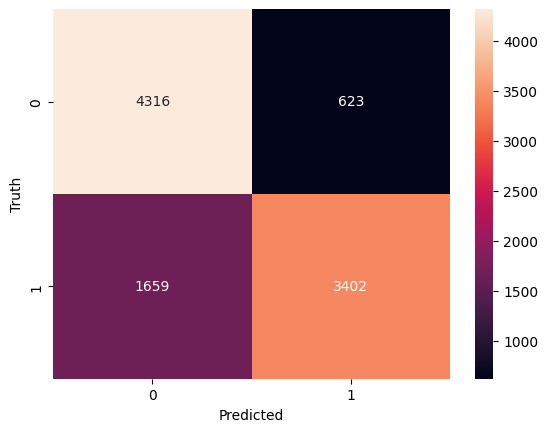

In [23]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
print(classification_report(y_test, y_predicted))


              precision    recall  f1-score   support

           0       0.72      0.87      0.79      4939
           1       0.85      0.67      0.75      5061

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

